In [369]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import copy
import pandas as pd
import numpy as np
import os
from time import time
import heapq


PRJ_ROOT_DIR = os.path.dirname(os.path.abspath(''))

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# prepare data 
from sklearn.model_selection import train_test_split, cross_val_predict, RepeatedStratifiedKFold
from sklearn.cluster import OPTICS, DBSCAN, Birch
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.preprocessing import StandardScaler

# model
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# evaluate
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix


# Utils

In [334]:
def stratify(df, frac, random_state):
    win_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    win_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    win_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    df_test = pd.concat([win_19_20,lose_19_20,draw_19_20,win_20_21,lose_20_21,draw_20_21,win_21_22,lose_21_22,draw_21_22], axis = 0)
    df_train = pd.concat([df,df_test]).drop_duplicates(keep=False)
    return df_train, df_test

In [335]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))


    
def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc,roc = predict_labels(clf, X_train, y_train)
    print("F1 score and accuracy score and roc score for training set: {:.4f} , {:.4f} , {:.4f}.".format(f1 , acc, roc))
    
    f1, acc, roc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score and roc score for test set: {:.4f} , {:.4f} , {:.4f}.".format(f1 , acc, roc))


In [336]:
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    y_pred = cross_val_predict(clf, features, target.squeeze(),cv = 3, method = 'predict_proba')
    y_pred_1 = cross_val_predict(clf, features, target.squeeze(),cv = 3, method = 'predict')
    return f1_score(target.squeeze(), y_pred_1, average='weighted'), accuracy_score(target.squeeze(), y_pred_1), roc_auc_score(target.squeeze(), y_pred, multi_class = 'ovo', average = 'macro')

In [337]:
def tuning(clf,param_dict,X_train, y_train, n_iter=50,cv=5,scoring="roc_auc_ovo",random_state=42,verbose=0):
    search_spaces = {}
    for param in clf.get_params().keys():
        if (str(clf.__class__.__name__) +'_'+param) in param_dict.keys():
            search_spaces[param] = param_dict[str(clf.__class__.__name__) +'_'+param]
    if search_spaces == {}:
        return clf
    search = BayesSearchCV(clf, search_spaces, 
                           n_iter=n_iter, cv=cv, scoring=scoring, 
                           random_state=random_state, n_jobs=-1, verbose=verbose)

    search.fit(X_train, y_train.squeeze())
    
    print(str(clf.__class__.__name__) +" best score :", search.best_score_)
    print(str(clf.__class__.__name__) +" best params:", search.best_params_)

    return search

# LDA Data

## 1. Load data

In [338]:
df = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "matches.csv"))
df

,home_result,season,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,...,2_23,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26
0,lose,2019/20,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,...,-100.000000,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758
1,win,2019/20,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,...,-0.780148,1.990417,-0.727778,-2.796785,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
2,win,2019/20,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,...,2.718124,2.234902,-0.764160,-0.524770,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
3,win,2019/20,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,...,-100.000000,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667
4,win,2019/20,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,...,0.878456,2.518209,-0.529214,-3.471708,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,2021/22,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,...,-1.604356,2.068204,-0.881599,-1.226240,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
1136,win,2021/22,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,...,-0.690187,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-100.000000,-100.000000,-100.000000
1137,lose,2021/22,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,...,-100.000000,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728
1138,win,2021/22,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,...,0.762411,1.627330,-1.141200,-1.083433,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000


### 1.1. Manage Empty Positions' Statistics

In [339]:
for i in df.columns:
    df[i].replace({-100 : min(df[df[i] != -100][i])}, inplace = True)
#     df[i].replace({-100 : 0}, inplace = True)
df


,home_result,season,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,...,2_23,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26
0,lose,2019/20,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,...,-1.983529,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758
1,win,2019/20,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,...,-0.780148,1.990417,-0.727778,-2.796785,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
2,win,2019/20,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,...,2.718124,2.234902,-0.764160,-0.524770,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
3,win,2019/20,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,...,-1.983529,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667
4,win,2019/20,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,...,0.878456,2.518209,-0.529214,-3.471708,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,2021/22,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,...,-1.604356,2.068204,-0.881599,-1.226240,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
1136,win,2021/22,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,...,-0.690187,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-2.726078,-2.250698,-1.944759
1137,lose,2021/22,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,...,-1.983529,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728
1138,win,2021/22,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,...,0.762411,1.627330,-1.141200,-1.083433,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759


## 2. Scale

In [340]:
df_scale =df[df.columns[2:]]
scaler = StandardScaler()
df_scale=scaler.fit_transform(df[df.columns[2:]])
df_scale = pd.DataFrame(df_scale, columns = df.columns[2:])
df_scale[['result','season'] ] = df[['home_result', 'season']]
df_scale


,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
0,0.691907,0.445105,0.742652,0.042331,0.613844,-0.862587,-0.461131,-1.377293,1.202706,-1.133726,...,0.044045,0.107089,1.157131,-0.262847,0.706244,0.851639,1.842932,1.612548,lose,2019/20
1,-0.353848,-1.635714,-1.061810,-0.406435,-0.400474,0.120296,-0.508685,-0.682614,0.571627,1.052813,...,0.077834,-0.652721,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
2,0.276728,0.166184,0.422733,-1.439769,-0.564281,3.497432,-1.589566,-1.341202,2.497509,-0.294670,...,-0.049201,0.775841,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
3,0.659372,-0.008889,0.112518,-0.927255,-0.427259,-0.909888,-1.514800,0.763674,-1.681124,0.181190,...,0.455852,0.136259,0.650373,0.383796,0.782694,1.491123,1.613412,1.621722,win,2019/20
4,1.015468,0.467920,1.006910,-0.477699,-0.708571,1.340446,0.246678,-1.325954,-0.876599,-0.401365,...,0.771163,-1.077088,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,0.307007,0.759104,0.374666,-0.348616,-0.221314,0.805854,0.646847,-0.206661,0.265198,-0.179956,...,-0.459264,0.334782,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2021/22
1136,-1.240417,-1.079340,-0.783214,-0.376142,0.413299,-0.131016,-1.173329,0.014460,1.005807,0.919869,...,-0.894251,-1.171614,0.497991,1.037266,0.426389,-0.705901,-0.673731,-0.641047,win,2021/22
1137,-0.020251,0.067909,-0.070839,0.493765,0.120881,0.567488,0.466027,-0.330500,1.170587,1.028132,...,-0.629230,-1.080432,0.582910,-0.071164,1.367343,1.605174,1.685267,0.828243,lose,2021/22
1138,0.480635,0.448583,0.035713,0.168699,-0.653782,1.100519,-0.610314,-0.047053,0.869983,-0.063290,...,-1.365720,0.424574,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2021/22


## 2.Trainset & Testset

In [341]:
df = df_scale
df_train, df_test = stratify(df, 0.1,42)
df_train, df_dev = stratify(df_train, 0.1,42)

In [342]:
print('Train size :',len(df_train))
print('Test size: ', len(df_test))
print('Dev size: ',len(df_dev))

Train size : 923
Test size:  113
Dev size:  104


In [343]:
df_train

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
1,-0.353848,-1.635714,-1.061810,-0.406435,-0.400474,0.120296,-0.508685,-0.682614,0.571627,1.052813,...,0.077834,-0.652721,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
2,0.276728,0.166184,0.422733,-1.439769,-0.564281,3.497432,-1.589566,-1.341202,2.497509,-0.294670,...,-0.049201,0.775841,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
3,0.659372,-0.008889,0.112518,-0.927255,-0.427259,-0.909888,-1.514800,0.763674,-1.681124,0.181190,...,0.455852,0.136259,0.650373,0.383796,0.782694,1.491123,1.613412,1.621722,win,2019/20
4,1.015468,0.467920,1.006910,-0.477699,-0.708571,1.340446,0.246678,-1.325954,-0.876599,-0.401365,...,0.771163,-1.077088,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
7,0.462053,1.167552,0.498313,-0.082414,-0.832897,0.313292,-0.354063,-0.728012,-0.260030,-0.683404,...,2.479299,0.750482,0.841596,1.684025,0.148662,0.959125,1.902204,1.080682,lose,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,0.307007,0.759104,0.374666,-0.348616,-0.221314,0.805854,0.646847,-0.206661,0.265198,-0.179956,...,-0.459264,0.334782,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2021/22
1136,-1.240417,-1.079340,-0.783214,-0.376142,0.413299,-0.131016,-1.173329,0.014460,1.005807,0.919869,...,-0.894251,-1.171614,0.497991,1.037266,0.426389,-0.705901,-0.673731,-0.641047,win,2021/22
1137,-0.020251,0.067909,-0.070839,0.493765,0.120881,0.567488,0.466027,-0.330500,1.170587,1.028132,...,-0.629230,-1.080432,0.582910,-0.071164,1.367343,1.605174,1.685267,0.828243,lose,2021/22
1138,0.480635,0.448583,0.035713,0.168699,-0.653782,1.100519,-0.610314,-0.047053,0.869983,-0.063290,...,-1.365720,0.424574,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2021/22


## 3. Outline removal

### 3.2. Isolation Forest

In [344]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
df_train['anomaly'] = model.fit_predict(df_train[df_train.columns[:-2]])
df_train.drop(df_train[df_train['anomaly'] == -1].index, inplace=True)
df_train.reset_index(inplace = True, drop = True)
df_train = df_train[df_train.columns[:-1]]
df_train

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
0,-0.353848,-1.635714,-1.061810,-0.406435,-0.400474,0.120296,-0.508685,-0.682614,0.571627,1.052813,...,0.077834,-0.652721,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
1,0.659372,-0.008889,0.112518,-0.927255,-0.427259,-0.909888,-1.514800,0.763674,-1.681124,0.181190,...,0.455852,0.136259,0.650373,0.383796,0.782694,1.491123,1.613412,1.621722,win,2019/20
2,1.015468,0.467920,1.006910,-0.477699,-0.708571,1.340446,0.246678,-1.325954,-0.876599,-0.401365,...,0.771163,-1.077088,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
3,0.462053,1.167552,0.498313,-0.082414,-0.832897,0.313292,-0.354063,-0.728012,-0.260030,-0.683404,...,2.479299,0.750482,0.841596,1.684025,0.148662,0.959125,1.902204,1.080682,lose,2019/20
4,1.198993,1.014524,1.294947,0.633782,0.674100,0.924512,0.582871,-0.746841,-0.330820,0.182761,...,0.064751,-1.433606,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,draw,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,-0.237541,0.201700,0.105896,-0.545312,-0.316024,-0.083649,-0.300958,-0.473961,-0.387220,-0.804845,...,-1.240767,0.426030,0.768656,1.140393,1.087840,1.085740,0.550599,0.849667,lose,2021/22
826,0.307007,0.759104,0.374666,-0.348616,-0.221314,0.805854,0.646847,-0.206661,0.265198,-0.179956,...,-0.459264,0.334782,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2021/22
827,-1.240417,-1.079340,-0.783214,-0.376142,0.413299,-0.131016,-1.173329,0.014460,1.005807,0.919869,...,-0.894251,-1.171614,0.497991,1.037266,0.426389,-0.705901,-0.673731,-0.641047,win,2021/22
828,-0.020251,0.067909,-0.070839,0.493765,0.120881,0.567488,0.466027,-0.330500,1.170587,1.028132,...,-0.629230,-1.080432,0.582910,-0.071164,1.367343,1.605174,1.685267,0.828243,lose,2021/22


### 3.3. Clustering

In [345]:
df_train['cluster'] = DBSCAN(min_samples=2, eps = 20).fit_predict(df_train[df_train.columns[:-2]])
df_train.drop(df_train[df_train['cluster'] == -1].index, inplace=True)
df_train.reset_index(inplace = True, drop = True)
df_train = df_train[df_train.columns[:-1]]
df_train

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
0,-0.353848,-1.635714,-1.061810,-0.406435,-0.400474,0.120296,-0.508685,-0.682614,0.571627,1.052813,...,0.077834,-0.652721,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
1,0.659372,-0.008889,0.112518,-0.927255,-0.427259,-0.909888,-1.514800,0.763674,-1.681124,0.181190,...,0.455852,0.136259,0.650373,0.383796,0.782694,1.491123,1.613412,1.621722,win,2019/20
2,1.015468,0.467920,1.006910,-0.477699,-0.708571,1.340446,0.246678,-1.325954,-0.876599,-0.401365,...,0.771163,-1.077088,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
3,0.462053,1.167552,0.498313,-0.082414,-0.832897,0.313292,-0.354063,-0.728012,-0.260030,-0.683404,...,2.479299,0.750482,0.841596,1.684025,0.148662,0.959125,1.902204,1.080682,lose,2019/20
4,1.198993,1.014524,1.294947,0.633782,0.674100,0.924512,0.582871,-0.746841,-0.330820,0.182761,...,0.064751,-1.433606,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,draw,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,-0.237541,0.201700,0.105896,-0.545312,-0.316024,-0.083649,-0.300958,-0.473961,-0.387220,-0.804845,...,-1.240767,0.426030,0.768656,1.140393,1.087840,1.085740,0.550599,0.849667,lose,2021/22
826,0.307007,0.759104,0.374666,-0.348616,-0.221314,0.805854,0.646847,-0.206661,0.265198,-0.179956,...,-0.459264,0.334782,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2021/22
827,-1.240417,-1.079340,-0.783214,-0.376142,0.413299,-0.131016,-1.173329,0.014460,1.005807,0.919869,...,-0.894251,-1.171614,0.497991,1.037266,0.426389,-0.705901,-0.673731,-0.641047,win,2021/22
828,-0.020251,0.067909,-0.070839,0.493765,0.120881,0.567488,0.466027,-0.330500,1.170587,1.028132,...,-0.629230,-1.080432,0.582910,-0.071164,1.367343,1.605174,1.685267,0.828243,lose,2021/22


### 3.4. Boxplot

In [346]:
columns = df_train.columns[:-2]
upper = []
lower = []
for i in columns :
    
    Q1 = np.percentile(df_train[i], 25,
                       interpolation = 'midpoint')

    Q3 = np.percentile(df_train[i], 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Upper bound
    upper += np.where(df_train[i] >= (Q3+1.5*IQR))[0].tolist()
#     print(upper)
    # Lower bound
    lower += np.where(df_train[i] <= (Q1-1.5*IQR))[0].tolist()

    ''' Removing the Outliers '''
index = upper+ lower
frq = [index.count(i) for i in range(len(df_train))]
# print([frq[i] for i in range(len(frq)) if frq[i] in heapq.nlargest(4, set(frq)) ])
df_train.drop([i for i in range(len(frq)) if frq[i] in heapq.nlargest(2, set(frq)) ], inplace = True)
df_train.reset_index(inplace = True, drop = True)
df_train

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
0,-0.353848,-1.635714,-1.061810,-0.406435,-0.400474,0.120296,-0.508685,-0.682614,0.571627,1.052813,...,0.077834,-0.652721,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
1,0.659372,-0.008889,0.112518,-0.927255,-0.427259,-0.909888,-1.514800,0.763674,-1.681124,0.181190,...,0.455852,0.136259,0.650373,0.383796,0.782694,1.491123,1.613412,1.621722,win,2019/20
2,1.015468,0.467920,1.006910,-0.477699,-0.708571,1.340446,0.246678,-1.325954,-0.876599,-0.401365,...,0.771163,-1.077088,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2019/20
3,0.462053,1.167552,0.498313,-0.082414,-0.832897,0.313292,-0.354063,-0.728012,-0.260030,-0.683404,...,2.479299,0.750482,0.841596,1.684025,0.148662,0.959125,1.902204,1.080682,lose,2019/20
4,1.198993,1.014524,1.294947,0.633782,0.674100,0.924512,0.582871,-0.746841,-0.330820,0.182761,...,0.064751,-1.433606,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,draw,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,-0.237541,0.201700,0.105896,-0.545312,-0.316024,-0.083649,-0.300958,-0.473961,-0.387220,-0.804845,...,-1.240767,0.426030,0.768656,1.140393,1.087840,1.085740,0.550599,0.849667,lose,2021/22
824,0.307007,0.759104,0.374666,-0.348616,-0.221314,0.805854,0.646847,-0.206661,0.265198,-0.179956,...,-0.459264,0.334782,-1.335966,-1.203925,-1.287487,-0.705901,-0.673731,-0.641047,win,2021/22
825,-1.240417,-1.079340,-0.783214,-0.376142,0.413299,-0.131016,-1.173329,0.014460,1.005807,0.919869,...,-0.894251,-1.171614,0.497991,1.037266,0.426389,-0.705901,-0.673731,-0.641047,win,2021/22
826,-0.020251,0.067909,-0.070839,0.493765,0.120881,0.567488,0.466027,-0.330500,1.170587,1.028132,...,-0.629230,-1.080432,0.582910,-0.071164,1.367343,1.605174,1.685267,0.828243,lose,2021/22


In [347]:
df_train.to_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "train.csv"), index = None)
df_test.to_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "test.csv"), index = None)
df_dev.to_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "dev.csv"), index = None)

## 6. Model

### 6.1. Load Data

In [348]:
train = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "train.csv"))
test = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "test.csv"))
dev = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "dev.csv"))

X_train = train.iloc[:,:-2]
y_train = train.iloc[:, -2].replace(['lose', 'win', 'draw'], [0, 2, 1])

X_test = test.iloc[:,:-2]
y_test = test.iloc[:, -2].replace(['lose', 'win', 'draw'], [0, 2, 1])

X_dev = dev.iloc[:,:-2]
y_dev = dev.iloc[:, -2].replace(['lose', 'win', 'draw'], [0, 2, 1])

### 6.2. Attribute selection

Feature: 0, Score: 0.01716
Feature: 1, Score: 0.01152
Feature: 2, Score: 0.01165
Feature: 3, Score: 0.01249
Feature: 4, Score: 0.01732
Feature: 5, Score: 0.01321
Feature: 6, Score: 0.01364
Feature: 7, Score: 0.01346
Feature: 8, Score: 0.01255
Feature: 9, Score: 0.01411
Feature: 10, Score: 0.01382
Feature: 11, Score: 0.01204
Feature: 12, Score: 0.01162
Feature: 13, Score: 0.01135
Feature: 14, Score: 0.01118
Feature: 18, Score: 0.01255
Feature: 19, Score: 0.01272
Feature: 20, Score: 0.01355
Feature: 21, Score: 0.01533
Feature: 22, Score: 0.01332
Feature: 23, Score: 0.01852
Feature: 24, Score: 0.01277
Feature: 25, Score: 0.01334
Feature: 26, Score: 0.01241
Feature: 27, Score: 0.01089
Feature: 28, Score: 0.01164
Feature: 29, Score: 0.01157
Feature: 33, Score: 0.01166
Feature: 34, Score: 0.01445
Feature: 35, Score: 0.01259
Feature: 42, Score: 0.01240
Feature: 43, Score: 0.01085
Feature: 44, Score: 0.01043
Feature: 45, Score: 0.01048
Feature: 46, Score: 0.01663
Feature: 47, Score: 0.01659
Fe

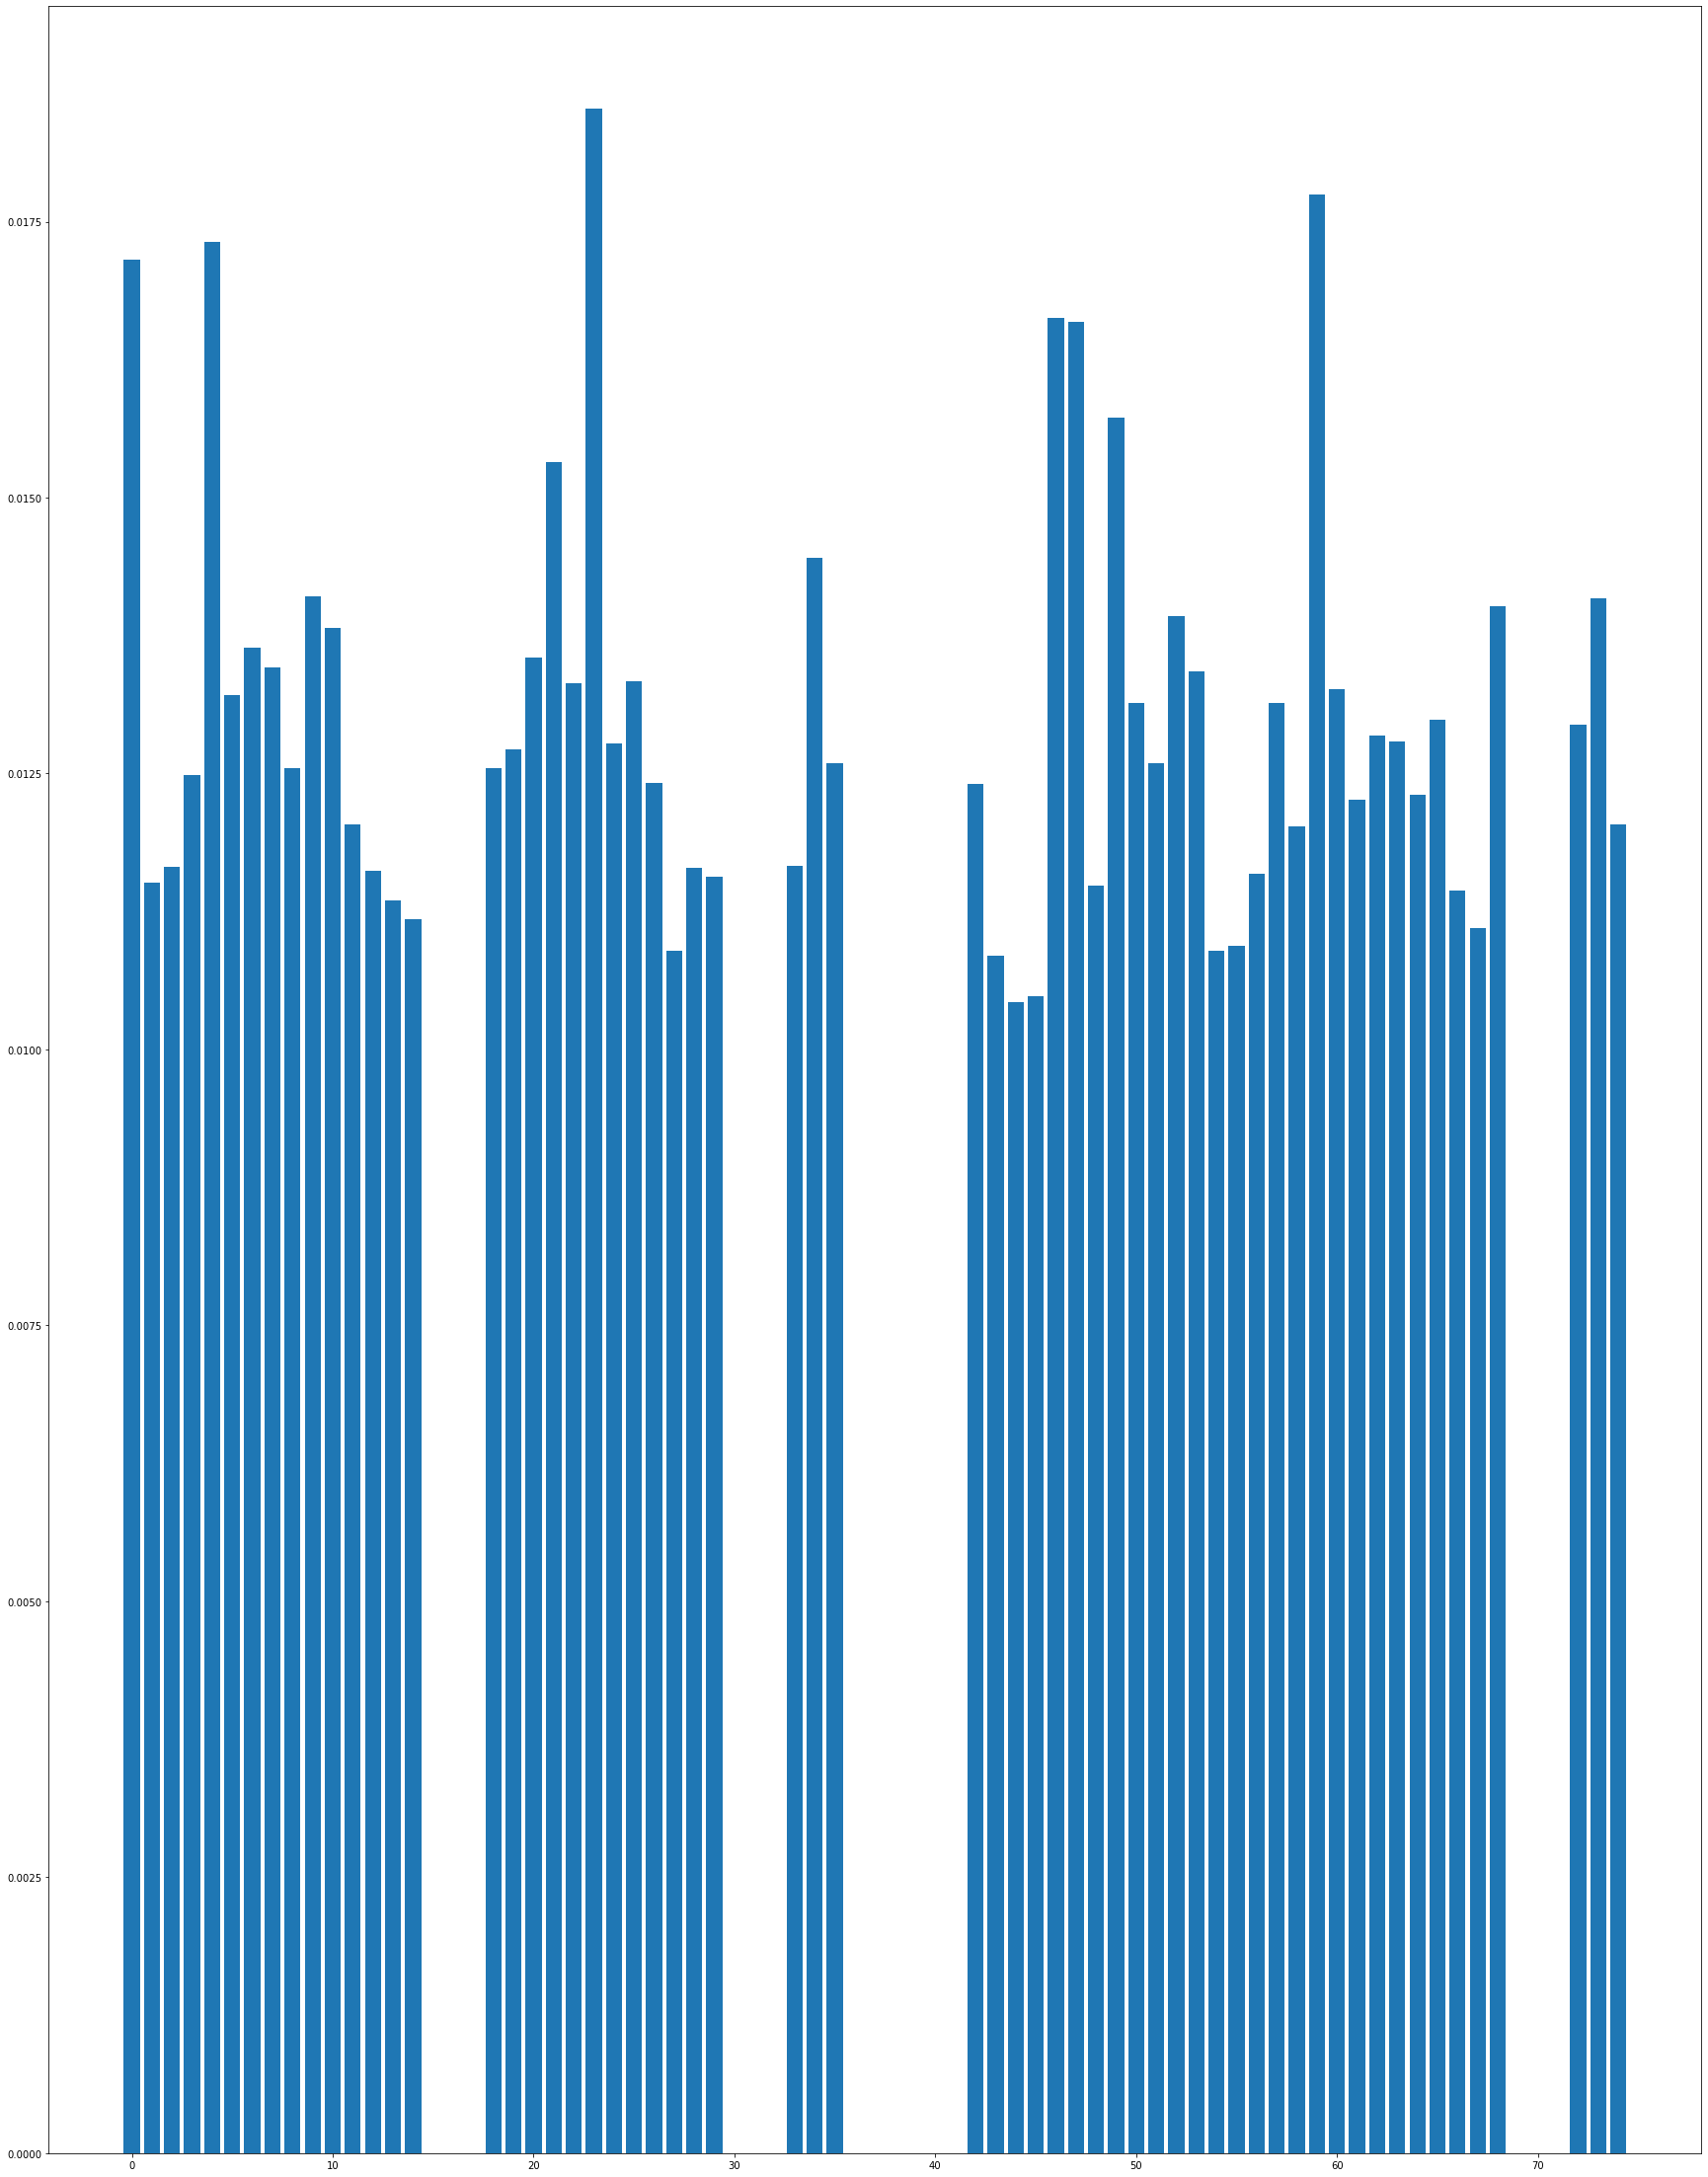

In [322]:
importance = np.zeros((1,81))
for i in range(10):
#     model = XGBClassifier()
    model = RandomForestClassifier()
    # fit the model
    model.fit(X_train, y_train)
    # get importance
    importance = np.concatenate((importance,[model.feature_importances_]), axis =0)
importance = importance.mean(axis =0 )
thes = 0.01
# summarize feature importance
idx = []
for i,v in enumerate(importance):
    if v > thes :
        idx.append(i)
        print('Feature: %0d, Score: %.5f' % (i,v))
print(len(idx),idx)
# plot feature importance
plt.figure(figsize=(30,40))
plt.bar([x for x in range(len(importance))if importance[x] >thes], [x for x in importance if x >thes])
plt.show()

In [323]:
X_train = X_train[X_train.columns[idx]]
X_test = X_test[X_test.columns[idx]]
X_train

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,2_20,0_21,1_21,2_21,0_22,1_22,2_22,0_24,1_24,2_24
0,-0.353848,-1.635714,-1.061810,-0.406435,-0.400474,0.120296,-0.508685,-0.682614,0.571627,1.052813,...,0.049072,0.827071,-0.953535,0.187222,1.749271,-0.255975,0.659934,-0.029824,0.077834,-0.652721
1,0.659372,-0.008889,0.112518,-0.927255,-0.427259,-0.909888,-1.514800,0.763674,-1.681124,0.181190,...,-0.434905,-1.395293,0.649530,0.567726,-0.861402,0.332459,0.077335,-0.056830,0.455852,0.136259
2,1.015468,0.467920,1.006910,-0.477699,-0.708571,1.340446,0.246678,-1.325954,-0.876599,-0.401365,...,1.120604,0.047373,-0.456871,0.879841,0.900428,-0.151725,0.870223,1.434140,0.771163,-1.077088
3,0.462053,1.167552,0.498313,-0.082414,-0.832897,0.313292,-0.354063,-0.728012,-0.260030,-0.683404,...,1.067565,0.239539,-0.024866,0.598892,-0.524624,0.446056,0.134643,-0.837104,2.479299,0.750482
4,1.198993,1.014524,1.294947,0.633782,0.674100,0.924512,0.582871,-0.746841,-0.330820,0.182761,...,1.452850,0.607727,-0.284143,-0.099271,-0.001992,-0.139753,0.796227,0.839039,0.064751,-1.433606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,-0.237541,0.201700,0.105896,-0.545312,-0.316024,-0.083649,-0.300958,-0.473961,-0.387220,-0.804845,...,0.074007,0.821334,-0.746702,0.132443,-1.360230,-1.376936,-1.655965,-0.334491,-1.240767,0.426030
824,0.307007,0.759104,0.374666,-0.348616,-0.221314,0.805854,0.646847,-0.206661,0.265198,-0.179956,...,0.131282,0.868437,-0.479653,-0.468377,0.716547,0.268153,0.307610,0.185937,-0.459264,0.334782
825,-1.240417,-1.079340,-0.783214,-0.376142,0.413299,-0.131016,-1.173329,0.014460,1.005807,0.919869,...,-0.446105,0.243776,-1.026251,0.436145,1.041652,0.082329,0.241855,0.110599,-0.894251,-1.171614
826,-0.020251,0.067909,-0.070839,0.493765,0.120881,0.567488,0.466027,-0.330500,1.170587,1.028132,...,0.660340,-1.901027,1.186990,-1.598504,-0.517181,1.095805,-0.110772,0.244059,-0.629230,-1.080432


### 6.3.Model

#### 6.3.1. Logistic Regression

In [349]:
lr = LogisticRegression(random_state = 42,multi_class="multinomial")
train_predict(lr, X_train, y_train, X_test, y_test)

Training a LogisticRegression using a training set size of 828. . .
Trained model in 0.0500 seconds
F1 score and accuracy score and roc score for training set: 0.4248 , 0.4384 , 0.5380.
F1 score and accuracy score and roc score for test set: 0.4412 , 0.4513 , 0.6030.


#### 6.3.2. XGBoost

In [350]:
xg = XGBClassifier(seed = 82, eval_metric = 'auc', objective = 'multi:softmax')
train_predict(xg, X_train, y_train, X_test, y_test)

Training a XGBClassifier using a training set size of 828. . .
Trained model in 1.3701 seconds
F1 score and accuracy score and roc score for training set: 0.3776 , 0.3925 , 0.5408.
F1 score and accuracy score and roc score for test set: 0.4503 , 0.4690 , 0.5818.


#### 6.3.3. Naive Bayes Gaussian

In [351]:
nb = GaussianNB()
train_predict(nb, X_train, y_train, X_test, y_test)

Training a GaussianNB using a training set size of 828. . .
Trained model in 0.0110 seconds
F1 score and accuracy score and roc score for training set: 0.3924 , 0.4420 , 0.5531.
F1 score and accuracy score and roc score for test set: 0.3916 , 0.4867 , 0.6006.


#### 6.3.4. Decision Tree

In [352]:
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
train_predict(dt, X_train, y_train, X_test, y_test)

Training a DecisionTreeClassifier using a training set size of 828. . .
Trained model in 0.0702 seconds
F1 score and accuracy score and roc score for training set: 0.3685 , 0.3659 , 0.5121.
F1 score and accuracy score and roc score for test set: 0.3797 , 0.3805 , 0.5166.


#### 6.3.5. Random Forest

In [353]:
rf = RandomForestClassifier(random_state=42)
train_predict(rf, X_train, y_train, X_test, y_test)

Training a RandomForestClassifier using a training set size of 828. . .
Trained model in 0.6012 seconds
F1 score and accuracy score and roc score for training set: 0.3843 , 0.4324 , 0.5306.
F1 score and accuracy score and roc score for test set: 0.3713 , 0.4248 , 0.5082.


#### 6.3.6. Ada Boost

In [354]:
ab = AdaBoostClassifier(learning_rate=0.7, n_estimators=100)
train_predict(ab, X_train, y_train, X_test, y_test)

Training a AdaBoostClassifier using a training set size of 828. . .
Trained model in 0.6949 seconds
F1 score and accuracy score and roc score for training set: 0.3504 , 0.3575 , 0.5135.
F1 score and accuracy score and roc score for test set: 0.3833 , 0.3982 , 0.5254.


#### 6.3.7. Gradient Boosting

In [355]:
gb = GradientBoostingClassifier(learning_rate=0.7, random_state=42)
train_predict(gb, X_train, y_train, X_test, y_test)

Training a GradientBoostingClassifier using a training set size of 828. . .
Trained model in 4.1671 seconds
F1 score and accuracy score and roc score for training set: 0.3965 , 0.3986 , 0.5440.
F1 score and accuracy score and roc score for test set: 0.3791 , 0.3982 , 0.5140.


#### 6.3.8. Support Vector Classification

In [356]:
svc = SVC(probability=True, random_state=42)
train_predict(svc, X_train, y_train, X_test, y_test)

Training a SVC using a training set size of 828. . .
Trained model in 0.5222 seconds
F1 score and accuracy score and roc score for training set: 0.4080 , 0.4686 , 0.5488.
F1 score and accuracy score and roc score for test set: 0.3709 , 0.4513 , 0.4213.


#### 6.3.9. Simple Neural Network

In [357]:
nn = MLPClassifier(random_state=42)
train_predict(nn, X_train, y_train, X_test, y_test)

Training a MLPClassifier using a training set size of 828. . .
Trained model in 1.4246 seconds
F1 score and accuracy score and roc score for training set: 0.3785 , 0.3853 , 0.5236.
F1 score and accuracy score and roc score for test set: 0.4589 , 0.4602 , 0.5903.


### 6.4. Hyperparameter tuning

##### 6.4.0. Parameter

In [358]:
param_dict = {  
    "XGBClassifier_eta": (0.01,0.2,"uniform"),
    "XGBClassifier_min_child_weight": (1,20),
    "XGBClassifier_max_depth": (3,10),
    
    "RandomForestClassifier_n_estimators": (5, 500), 
    "RandomForestClassifier_criterion": ["gini", "entropy"],
    "RandomForestClassifier_max_depth": (1, 19), # 19 overfits the data
    "RandomForestClassifier_min_samples_split": (2, 20),
    "RandomForestClassifier_max_features": [None, "sqrt", "log2"],
    "RandomForestClassifier_max_leaf_nodes": (2, 159),
    "RandomForestClassifier_min_impurity_decrease": (1e-6, 0.5, "uniform"),
    "RandomForestClassifier_max_samples": (0.5, 1.0, "uniform"),
        
    "GradientBoostingClassifier_n_estimators": (2, 100),
    "GradientBoostingClassifier_learning_rate": Real(low=0.001, high=3, prior="uniform"),
    "GradientBoostingClassifier_subsample": Real(low=0.05, high=1.0, prior="uniform"),
    "GradientBoostingClassifier_criterion": ["friedman_mse", "squared_error"],
    "GradientBoostingClassifier_min_samples_split": Real(low=1e-6, high=1.0, prior="uniform"),
    "GradientBoostingClassifier_max_depth": (1, 10),
    "GradientBoostingClassifier_min_impurity_decrease": Real(low=1e-6, high=0.5, prior="uniform"),
    "GradientBoostingClassifier_max_features": [None, "sqrt", "log2"],
    "GradientBoostingClassifier_max_leaf_nodes": (2, 100),
                  
    "AdaBoostClassifier_n_estimators": (2, 500),
    "AdaBoostClassifier_learning_rate": Real(low=0.001, high=3,  prior='uniform'),
                  
    "SVC_C": Real(low=1e-6, high=2, prior="uniform"),
    "SVC_kernel": ["linear", "poly", "rbf", "sigmoid"],
    "SVC_degree": (2, 30),
    "SVC_gamma": ["scale", "auto"]
    }

#### 6.4.1. Logistic Regression

In [359]:
lr_t = tuning(lr,param_dict,X_train, y_train)
train_predict(lr_t, X_train, y_train, X_test, y_test)

Training a LogisticRegression using a training set size of 828. . .
Trained model in 0.0557 seconds
F1 score and accuracy score and roc score for training set: 0.4248 , 0.4384 , 0.5380.
F1 score and accuracy score and roc score for test set: 0.4412 , 0.4513 , 0.6030.


#### 6.4.2. XGBoost

In [360]:
xg_t = tuning(xg,param_dict,X_train, y_train)
train_predict(xg_t, X_train, y_train, X_test, y_test)

XGBClassifier best score : 0.5762505959595253
XGBClassifier best params: OrderedDict([('max_depth', 3), ('min_child_weight', 9)])
Training a BayesSearchCV using a training set size of 828. . .
Trained model in 270.1267 seconds
F1 score and accuracy score and roc score for training set: 0.3951 , 0.4034 , 0.5497.
F1 score and accuracy score and roc score for test set: 0.4096 , 0.4425 , 0.5615.


#### 6.4.3. Naive Bayes Gaussian

In [361]:
nb_t = tuning(nb,param_dict,X_train, y_train)
train_predict(nb_t, X_train, y_train, X_test, y_test)

Training a GaussianNB using a training set size of 828. . .
Trained model in 0.0156 seconds
F1 score and accuracy score and roc score for training set: 0.3924 , 0.4420 , 0.5531.
F1 score and accuracy score and roc score for test set: 0.3916 , 0.4867 , 0.6006.


#### 6.4.4. Decision Tree

In [362]:
dt_t = tuning(dt,param_dict,X_train, y_train)
train_predict(tuning(dt,param_dict,X_train, y_train), X_train, y_train, X_test, y_test)

Training a DecisionTreeClassifier using a training set size of 828. . .
Trained model in 0.0640 seconds
F1 score and accuracy score and roc score for training set: 0.3685 , 0.3659 , 0.5121.
F1 score and accuracy score and roc score for test set: 0.3797 , 0.3805 , 0.5166.


#### 6.4.5. Random Forest

In [363]:
rf_t = tuning(rf,param_dict,X_train, y_train)
train_predict(rf_t, X_train, y_train, X_test, y_test)

RandomForestClassifier best score : 0.5999766243571234
RandomForestClassifier best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('max_leaf_nodes', 2), ('max_samples', 0.5212415297856632), ('min_impurity_decrease', 0.06187806219973551), ('min_samples_split', 18), ('n_estimators', 296)])
Training a BayesSearchCV using a training set size of 828. . .
Trained model in 257.6373 seconds
F1 score and accuracy score and roc score for training set: 0.3585 , 0.4481 , 0.5544.
F1 score and accuracy score and roc score for test set: 0.3891 , 0.4336 , 0.5468.


#### 6.4.6. Ada Boost

In [364]:
ab_t = tuning(ab,param_dict,X_train, y_train)
train_predict(ab_t, X_train, y_train, X_test, y_test)

AdaBoostClassifier best score : 0.5725526435106278
AdaBoostClassifier best params: OrderedDict([('learning_rate', 0.001), ('n_estimators', 355)])
Training a BayesSearchCV using a training set size of 828. . .
Trained model in 283.5842 seconds
F1 score and accuracy score and roc score for training set: 0.4227 , 0.4324 , 0.4819.
F1 score and accuracy score and roc score for test set: 0.3546 , 0.3894 , 0.4697.


#### 6.4.7. Gradient Boosting

In [365]:
gb_t = tuning(gb,param_dict,X_train, y_train)
train_predict(gb_t, X_train, y_train, X_test, y_test)

GradientBoostingClassifier best score : 0.58142226138339
GradientBoostingClassifier best params: OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.043693584827101034), ('max_depth', 1), ('max_features', 'sqrt'), ('max_leaf_nodes', 28), ('min_impurity_decrease', 0.3547429945246099), ('min_samples_split', 1e-06), ('n_estimators', 100), ('subsample', 0.893691781716231)])
Training a BayesSearchCV using a training set size of 828. . .
Trained model in 178.5096 seconds
F1 score and accuracy score and roc score for training set: 0.3687 , 0.4130 , 0.5346.
F1 score and accuracy score and roc score for test set: 0.4357 , 0.4425 , 0.5790.


#### 6.4.8. Support Vector Classification

In [366]:
svc_t = tuning(svc,param_dict,X_train, y_train)
train_predict(svc_t, X_train, y_train, X_test, y_test)

SVC best score : 0.5791689845458892
SVC best params: OrderedDict([('C', 0.03109971219039), ('degree', 2), ('gamma', 'auto'), ('kernel', 'linear')])
Training a BayesSearchCV using a training set size of 828. . .
Trained model in 223.7692 seconds
F1 score and accuracy score and roc score for training set: 0.3804 , 0.4287 , 0.5504.
F1 score and accuracy score and roc score for test set: 0.3656 , 0.4248 , 0.4588.


#### 6.4.9. Simple Neural Network

In [367]:
nn_t = tuning(nn,param_dict,X_train, y_train)
train_predict(nn_t, X_train, y_train, X_test, y_test)

Training a MLPClassifier using a training set size of 828. . .
Trained model in 1.4383 seconds
F1 score and accuracy score and roc score for training set: 0.3785 , 0.3853 , 0.5236.
F1 score and accuracy score and roc score for test set: 0.4589 , 0.4602 , 0.5903.


## 7. Summary

In [379]:
print(classification_report(y_test, nn.predict(X_test), target_names=["draw", "lose", "win"]))

              precision    recall  f1-score   support

        draw       0.55      0.55      0.55        40
        lose       0.33      0.31      0.32        26
         win       0.67      0.70      0.69        47

    accuracy                           0.56       113
   macro avg       0.52      0.52      0.52       113
weighted avg       0.55      0.56      0.55       113



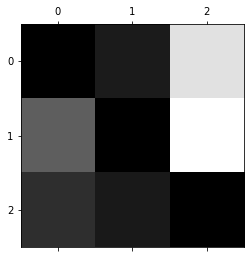

In [386]:

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
conf_mx = confusion_matrix(y, nb.predict(X))
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)